## Mapping New York

## Steps

3. Geographic data - shapefiles for NY State at the census tract level
   - create a GEO DataFrame for NY State, "geodf_tract_ny"
   - open population DataFrame, "df_census_pop"
   - merge the two on "GEOID Census Tract"
   - add a new column that calculates population density
   - map NY state census tracts with population desnity in Kepler
   - load the "Places" DataFrame 
   - make a NYC Place DataFrame
   - map NYC

### Data Sources

Below are the data sources used for this section of the project and the specific steps I followed to access them.

***Geographic Data:***

Files downloaded from the Census Bureau's FTP server archive via FTP client

*2020 Census Redistricting Data (P.L. 94-171) Shapefiles - census tract level, NY State*
* file location: ftp2.census.gov/geo/tiger/TIGER2020PL/LAYER/TRACT/2020
* files names beginning with "tl_2020_36" (NY State FIPS code is 36)

*2020 Census Redistricting Data (P.L. 94-171) Shapefiles - places level, NY State*
* file location: ftp2.census.gov/geo/tiger/TIGER2020PL/LAYER/PLACE/2020
* files name: tl_2020_36_place20.zip  (36 for NY State)

In [1]:
import os, pathlib
base_dir = pathlib.Path(os.getcwd()).parent
data_archive_dir = os.path.join(base_dir, "data_archive")
clean_data_dir = os.path.join(data_archive_dir, "clean")
data_dir = os.path.join(base_dir, "data")
shapes_dir = os.path.join(data_dir,"shapes")
json_dir = os.path.join(data_dir,"geojson")

## Population Data

Let's bring in as a DataFrame the US population data we cleaned earlier. We'll be merging it with our NY State geographic data shortly.

In [2]:
import pandas as pd

clean_census_pop_file = os.path.join(clean_data_dir, 'census_pop.csv')
df_census_pop = pd.read_csv(clean_census_pop_file, low_memory=False, dtype={'GEOID Census Tract Full': 'str', 'Census Tract Name':'str', 'Population':'int', 'GEOID Census Tract': 'int'}, index_col=0)
df_census_pop.head(3)

,GEOID Census Tract Full,Census Tract Name,Population,GEOID Census Tract
1,1400000US01001020100,"Census Tract 201, Autauga County, Alabama",1775,1001020100
2,1400000US01001020200,"Census Tract 202, Autauga County, Alabama",2055,1001020200
3,1400000US01001020300,"Census Tract 203, Autauga County, Alabama",3216,1001020300


In [3]:
df_census_pop.dtypes

GEOID Census Tract Full    object
Census Tract Name          object
Population                  int64
GEOID Census Tract          int64
dtype: object

In [4]:
# df_census_pop[df_census_pop.isna().any(axis=1)]
len(df_census_pop)
len(df_census_pop[(df_census_pop['Population'] == 0) & (df_census_pop['Census Tract Name'].str.endswith('New York'))])

53

## Mapping the Population Density of NY State

The Census Bureau provides geographic information in shapefile format. Let's load the NY State Census Tract shapefiles as a GEO DataFrame and call it *geodf_tract_ny*.

In [5]:
# Uses the geopandas function read_file to grab our file
import geopandas as gpd

# the re module provides regex matching operations
import re 

In [6]:
shapefile_tract = os.path.join(shapes_dir,"tiger2020PL_NY_tracts") # provide the full path to our shapefiles
# shapefile_tract_ny=[x for x in pathlib.Path(shapefile_tract).iterdir() if x.is_file()] # make a list of all the files in the directory with their full path

tract_file_re = "tl_2020_[0-9]{5}" # use regex to find filenames containing a digit in the range 0-9, repeated 5 times 
shapefile_tract_ny=[x for x in pathlib.Path(shapefile_tract).iterdir() if x.is_file() and re.search(tract_file_re, x.name)] # make a list of all files in the dir with their full path, as long as they meet above criteria

In [7]:
#import re
#tract_file_re = "tl_2020_[0-9]{5}"
#for file in shapefile_tract_ny:
#    print(f"{file.name} {re.search(tract_file_re,file.name)}")

In [8]:
geodf_tract_ny = pd.DataFrame() # create any empty DataFrame
for file in shapefile_tract_ny: # for every file in our list of shapefiles
    gpd.read_file(file) # read the file into a GEO DataFrame
    geodf_tract_ny = pd.concat([geodf_tract_ny, gpd.read_file(file)], ignore_index=True, copy=False) # concatenate each GEO DataFrame to geodf_tract_ny

# Select only the columns we want from the DataFrame 
geodf_tract_ny = geodf_tract_ny[['STATEFP20', 'COUNTYFP20', 'TRACTCE20', 'GEOID20', 'ALAND20', 'geometry']]

# Make sure the data types of each column are as we want them to be
geodf_tract_ny = geodf_tract_ny.astype({'STATEFP20': 'int', 'COUNTYFP20':'int', 'TRACTCE20':'int', 'GEOID20': 'int', 'ALAND20': 'int'})

# Rename the columns
geodf_tract_ny = geodf_tract_ny.rename(columns={'STATEFP20': 'State FIPS', 'COUNTYFP20': 'County FIPS', 'TRACTCE20': 'Census Tract Code', 'GEOID20': 'GEOID Census Tract', 'ALAND20': 'Land Area'})

geodf_tract_ny.head(3)

,State FIPS,County FIPS,Census Tract Code,GEOID Census Tract,Land Area,geometry
0,36,25,970101,36025970101,108853793,"POLYGON ((-74.79374 42.49635, -74.79359 42.496..."
1,36,25,970102,36025970102,133548339,"POLYGON ((-75.05907 42.43064, -75.05219 42.430..."
2,36,25,970200,36025970200,312229586,"POLYGON ((-75.04411 42.37059, -75.04274 42.371..."


In [9]:
geodf_tract_ny[ geodf_tract_ny['GEOID Census Tract'] == 36025970101 ]

,State FIPS,County FIPS,Census Tract Code,GEOID Census Tract,Land Area,geometry
0,36,25,970101,36025970101,108853793,"POLYGON ((-74.79374 42.49635, -74.79359 42.496..."


In [10]:
geodf_tract_ny.shape

(5411, 6)

In [11]:
geodf_tract_ny.dtypes

State FIPS               int64
County FIPS              int64
Census Tract Code        int64
GEOID Census Tract       int64
Land Area                int64
geometry              geometry
dtype: object

In [12]:
# check for null values
geodf_tract_ny[geodf_tract_ny.isna().any(axis=1)]

,State FIPS,County FIPS,Census Tract Code,GEOID Census Tract,Land Area,geometry


Bring in population data by merging *df_census_pop* into *geodf_tract_ny* on column "GEOID Census Tract".

In [13]:
geodf_tract_ny = geodf_tract_ny.merge(df_census_pop, on=['GEOID Census Tract'])
geodf_tract_ny = geodf_tract_ny[['State FIPS', 'County FIPS', 'Census Tract Name', 'GEOID Census Tract', 'Population', 'Land Area', 'geometry']]
geodf_tract_ny.head()
len(geodf_tract_ny) # make sure our merge hasn't inadvertantly changed length, should still be 5411

5411

Calculate population density.

In [14]:
# add a column to calculate population density
# land area measured in whole sq meters
# sq miles = sq meters/2,589,988 
# population density in sq miles  = population/ (land area sq meters / 2,589,988)
geodf_tract_ny['Population Density'] = (geodf_tract_ny['Population']/(geodf_tract_ny['Land Area']/2589988)).round(0)
geodf_tract_ny = geodf_tract_ny[['State FIPS', 'County FIPS', 'Census Tract Name', 'GEOID Census Tract', 'Population', 'Land Area', 'Population Density', 'geometry']]
geodf_tract_ny.head(3)

,State FIPS,County FIPS,Census Tract Name,GEOID Census Tract,Population,Land Area,Population Density,geometry
0,36,25,"Census Tract 9701.01, Delaware County, New York",36025970101,1442,108853793,34.0,"POLYGON ((-74.79374 42.49635, -74.79359 42.496..."
1,36,25,"Census Tract 9701.02, Delaware County, New York",36025970102,2955,133548339,57.0,"POLYGON ((-75.05907 42.43064, -75.05219 42.430..."
2,36,25,"Census Tract 9702, Delaware County, New York",36025970200,3028,312229586,25.0,"POLYGON ((-75.04411 42.37059, -75.04274 42.371..."


In [15]:
# check for tracts where population == 0 because these will result in Population Density of NaN
# replace the NaNs with 0s
geodf_tract_ny[geodf_tract_ny['Population'] == 0]
geodf_tract_ny['Population Density'] = geodf_tract_ny['Population Density'].fillna(0)
geodf_tract_ny['Population Density'] = geodf_tract_ny['Population Density'].astype(int) # change dtype to integer

In [16]:
geodf_tract_ny.dtypes

State FIPS               int64
County FIPS              int64
Census Tract Name       object
GEOID Census Tract       int64
Population               int64
Land Area                int64
Population Density       int64
geometry              geometry
dtype: object

In [17]:
geodf_tract_ny.shape

(5411, 8)

In [18]:
# df_state = pd.read_csv(file_state, 
#                        usecols=['STATE', 'STUSAB', 'STATE_NAME'], # use only these columns
#                        delimiter="|", # load txt file as pandas DataFrame 
#                        encoding="iso-8859-1", 
#                        encoding_errors='ignore')[['STATE_NAME', 'STUSAB', 'STATE',]] # reorder cols

### Outlining the place "New York City"

First, let's bring in as a DataFrame the "Places" list we cleaned earlier. 

In [19]:
clean_place_file = os.path.join(clean_data_dir, 'place.csv')
df_place = pd.read_csv(clean_place_file, index_col=0)
df_place.head(3)

,State Name,State,State FIPS,Place,Place FIPS,County
0,Alabama,AL,1,Abanda Cdp,100,Chambers County
1,Alabama,AL,1,Abbeville City,124,Henry County
2,Alabama,AL,1,Adamsville City,460,Jefferson County


In [20]:
df_place[df_place['Place'] == "New York City"]

,State Name,State,State FIPS,Place,Place FIPS,County
24316,New York,NY,36,New York City,51000,"Bronx County, Kings County, New York County, Q..."


In [21]:
df_place.dtypes

State Name    object
State         object
State FIPS     int64
Place         object
Place FIPS     int64
County        object
dtype: object

In [22]:
# make GEO DataFrame from the NY State "places" shapefiles
shapefile_place_ny = os.path.join(shapes_dir,"tl_2020_36_place20.zip")
geodf_place_ny = gpd.read_file(shapefile_place_ny,  
                            encoding_errors='ignore')

# Select only the columns we want from the DataFrame 
geodf_place_ny = geodf_place_ny[['STATEFP20', 'PLACEFP20', 'GEOID20', 'NAME20', 'ALAND20', 'geometry']]

# rename the columns
geodf_place_ny.rename(columns={'STATEFP20': 'State FIPS', 'PLACEFP20': 'Place FIPS', 'GEOID20': 'GEOID', 'NAME20': 'Name', 'ALAND20': 'Land Area'}, inplace=True)

# Make sure the data types of each column are as we want them to be
geodf_place_ny['State FIPS'] = geodf_place_ny['State FIPS'].astype(int)
geodf_place_ny['Place FIPS'] = geodf_place_ny['Place FIPS'].astype(int)
geodf_place_ny['GEOID'] = geodf_place_ny['GEOID'].astype(int)

geodf_place_ny

,State FIPS,Place FIPS,GEOID,Name,Land Area,geometry
0,36,1517,3601517,Altamont,3279144,"MULTIPOLYGON (((-74.02271 42.70420, -74.02231 ..."
1,36,56979,3656979,Peekskill,11251161,"POLYGON ((-73.95544 41.27786, -73.95204 41.280..."
2,36,18388,3618388,Cortland,10085376,"POLYGON ((-76.20049 42.61248, -76.19596 42.612..."
3,36,35276,3635276,Homer,4986794,"POLYGON ((-76.20248 42.63292, -76.20161 42.633..."
4,36,42147,3642147,Lewiston,2840234,"POLYGON ((-79.05292 43.17400, -79.05287 43.177..."
...,...,...,...,...,...,...
1288,36,83426,3683426,Yaphank,35336639,"POLYGON ((-72.96103 40.85172, -72.96021 40.851..."
1289,36,84011,3684011,York,7133085,"POLYGON ((-77.90695 42.87215, -77.90689 42.873..."
1290,36,84044,3684044,Yorkshire,4778096,"POLYGON ((-78.49301 42.51619, -78.49283 42.519..."
1291,36,84088,3684088,Yorktown Heights,2379367,"POLYGON ((-73.78428 41.27440, -73.78427 41.274..."


In [23]:
geodf_place_ny.dtypes

State FIPS       int64
Place FIPS       int64
GEOID            int64
Name            object
Land Area        int64
geometry      geometry
dtype: object

For some reason, the place names are inconsistent between our places shapefiles and our places list. Specifically, Place FIPS 51000 is referred to by our places list as "New York City", while as we can see below, our shapefile refers to it as "New York". This is confusing! We like the version in our places list and would rather use this. So, let's bring in the merge *shapefile_place_ny* with *df_place* to bring in the "Place" column we like from our place list.

In [24]:
geodf_place_ny[geodf_place_ny['Place FIPS'] == 51000]

,State FIPS,Place FIPS,GEOID,Name,Land Area,geometry
398,36,51000,3651000,New York,778165283,"MULTIPOLYGON (((-74.04075 40.70017, -74.04073 ..."


In [25]:
# don't include "name"
geodf_place_ny = geodf_place_ny.merge(df_place, on =['State FIPS', 'Place FIPS'])
geodf_place_ny = geodf_place_ny[['State Name', 'State', 'State FIPS', 'Place', 'Place FIPS', 'County', 'Land Area', 'geometry']]
geodf_place_ny.head()

,State Name,State,State FIPS,Place,Place FIPS,County,Land Area,geometry
0,New York,NY,36,Altamont Village,1517,Albany County,3279144,"MULTIPOLYGON (((-74.02271 42.70420, -74.02231 ..."
1,New York,NY,36,Peekskill City,56979,Westchester County,11251161,"POLYGON ((-73.95544 41.27786, -73.95204 41.280..."
2,New York,NY,36,Peekskill City,56979,Westchester County,11251161,"POLYGON ((-73.95544 41.27786, -73.95204 41.280..."
3,New York,NY,36,Cortland City,18388,Cortland County,10085376,"POLYGON ((-76.20049 42.61248, -76.19596 42.612..."
4,New York,NY,36,Cortland City,18388,Cortland County,10085376,"POLYGON ((-76.20049 42.61248, -76.19596 42.612..."


In [26]:
geodf_place_ny.dtypes

State Name      object
State           object
State FIPS       int64
Place           object
Place FIPS       int64
County          object
Land Area        int64
geometry      geometry
dtype: object

In [27]:
geodf_place_nyc = geodf_place_ny[geodf_place_ny['Place FIPS'] == 51000]

In [28]:
from keplergl import KeplerGl
ny_map = KeplerGl( height=600, show_docs=False)
ny_map.add_data(geodf_tract_ny, name='NY State') # map NY state, should include Population Density?
ny_map.add_data(geodf_place_nyc, name='New York City')
# ny_map.add_data(ny_tract_shapes_df, name='Population') 


<AxesSubplot:>

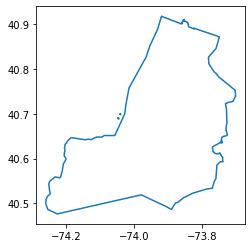

In [29]:
#geodf_place_nyc["geometry"].explode().iloc[2]
geodf_place_nyc.boundary.plot()

In [30]:
ny_map.config = {
    "version": "v1",
    "config": {
        "visState": {
            "filters": [],
            "layers": [
                {
                    "id": "5xtj533",
                    "type": "geojson",
                    "config": {
                        "dataId": "New York City",
                        "label": "New York City",
                        "color": [
                            183,
                            136,
                            94
                        ],
                        "highlightColor": [
                            252,
                            242,
                            26,
                            255
                        ],
                        "columns": {
                            "geojson": "geometry"
                        },
                        "isVisible": True,
                        "visConfig": {
                            "opacity": 0.8,
                            "strokeOpacity": 0.8,
                            "thickness": 1.6,
                            "strokeColor": [
                                125,
                                201,
                                127
                            ],
                            "colorRange": {
                                "name": "Global Warming",
                                "type": "sequential",
                                "category": "Uber",
                                "colors": [
                                    "#5A1846",
                                    "#900C3F",
                                    "#C70039",
                                    "#E3611C",
                                    "#F1920E",
                                    "#FFC300"
                                ]
                            },
                            "strokeColorRange": {
                                "name": "Global Warming",
                                "type": "sequential",
                                "category": "Uber",
                                "colors": [
                                    "#5A1846",
                                    "#900C3F",
                                    "#C70039",
                                    "#E3611C",
                                    "#F1920E",
                                    "#FFC300"
                                ]
                            },
                            "radius": 10,
                            "sizeRange": [
                                0,
                                10
                            ],
                            "radiusRange": [
                                0,
                                50
                            ],
                            "heightRange": [
                                0,
                                500
                            ],
                            "elevationScale": 5,
                            "enableElevationZoomFactor": True,
                            "stroked": True,
                            "filled": False,
                            "enable3d": False,
                            "wireframe": False
                        },
                        "hidden": False,
                        "textLabel": [
                            {
                                "field": None,
                                "color": [
                                    255,
                                    255,
                                    255
                                ],
                                "size": 18,
                                "offset": [
                                    0,
                                    0
                                ],
                                "anchor": "start",
                                "alignment": "center"
                            }
                        ]
                    },
                    "visualChannels": {
                        "colorField": None,
                        "colorScale": "quantile",
                        "strokeColorField": None,
                        "strokeColorScale": "quantile",
                        "sizeField": None,
                        "sizeScale": "linear",
                        "heightField": None,
                        "heightScale": "linear",
                        "radiusField": None,
                        "radiusScale": "linear"
                    }
                },
                {
                    "id": "3xpf35a",
                    "type": "geojson",
                    "config": {
                        "dataId": "NY State",
                        "label": "NY State",
                        "color": [
                            23,
                            184,
                            190
                        ],
                        "highlightColor": [
                            252,
                            242,
                            26,
                            255
                        ],
                        "columns": {
                            "geojson": "geometry"
                        },
                        "isVisible": True,
                        "visConfig": {
                            "opacity": 0.8,
                            "strokeOpacity": 0.8,
                            "thickness": 0.5,
                            "strokeColor": [
                                246,
                                209,
                                138
                            ],
                            "colorRange": {
                                "name": "Global Warming",
                                "type": "sequential",
                                "category": "Uber",
                                "colors": [
                                    "#5A1846",
                                    "#900C3F",
                                    "#C70039",
                                    "#E3611C",
                                    "#F1920E",
                                    "#FFC300"
                                ]
                            },
                            "strokeColorRange": {
                                "name": "Global Warming",
                                "type": "sequential",
                                "category": "Uber",
                                "colors": [
                                    "#5A1846",
                                    "#900C3F",
                                    "#C70039",
                                    "#E3611C",
                                    "#F1920E",
                                    "#FFC300"
                                ]
                            },
                            "radius": 10,
                            "sizeRange": [
                                0,
                                10
                            ],
                            "radiusRange": [
                                0,
                                50
                            ],
                            "heightRange": [
                                0,
                                500
                            ],
                            "elevationScale": 5,
                            "enableElevationZoomFactor": True,
                            "stroked": False,
                            "filled": True,
                            "enable3d": False,
                            "wireframe": False
                        },
                        "hidden": False,
                        "textLabel": [
                            {
                                "field": None,
                                "color": [
                                    255,
                                    255,
                                    255
                                ],
                                "size": 18,
                                "offset": [
                                    0,
                                    0
                                ],
                                "anchor": "start",
                                "alignment": "center"
                            }
                        ]
                    },
                    "visualChannels": {
                        "colorField": {
                            "name": "Population Density",
                            "type": "integer"
                        },
                        "colorScale": "quantile",
                        "strokeColorField": None,
                        "strokeColorScale": "quantile",
                        "sizeField": None,
                        "sizeScale": "linear",
                        "heightField": None,
                        "heightScale": "linear",
                        "radiusField": None,
                        "radiusScale": "linear"
                    }
                }
            ],
            "interactionConfig": {
                "tooltip": {
                    "fieldsToShow": {
                        "NY State": [
                            {
                                "name": "State FIPS",
                                "format": None
                            },
                            {
                                "name": "County FIPS",
                                "format": None
                            },
                            {
                                "name": "Census Tract Code",
                                "format": None
                            },
                            {
                                "name": "GEOID Census Tract",
                                "format": None
                            },
                            {
                                "name": "Land Area",
                                "format": None
                            }
                        ],
                        "New York City": [
                            {
                                "name": "State Name",
                                "format": None
                            },
                            {
                                "name": "State",
                                "format": None
                            },
                            {
                                "name": "State FIPS",
                                "format": None
                            },
                            {
                                "name": "Place",
                                "format": None
                            },
                            {
                                "name": "Place FIPS",
                                "format": None
                            }
                        ]
                    },
                    "compareMode": False,
                    "compareType": "absolute",
                    "enabled": True
                },
                "brush": {
                    "size": 0.5,
                    "enabled": False
                },
                "geocoder": {
                    "enabled": False
                },
                "coordinate": {
                    "enabled": False
                }
            },
            "layerBlending": "additive",
            "splitMaps": [],
            "animationConfig": {
                "currentTime": None,
                "speed": 1
            }
        },
        "mapState": {
            "bearing": 0,
            "dragRotate": False,
            "latitude": 42.93740667647843,
            "longitude": -77.20412718754224,
            "pitch": 0,
            "zoom": 6,
            "isSplit": False
        },
        "mapStyle": {
            "styleType": "dark",
            "topLayerGroups": {},
            "visibleLayerGroups": {
                "label": True,
                "road": True,
                "border": False,
                "building": True,
                "water": True,
                "land": True,
                "3d building": False
            },
            "threeDBuildingColor": [
                9.665468314072013,
                17.18305478057247,
                31.1442867897876
            ],
            "mapStyles": {}
        }
    }
}


In [31]:
ny_map

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '5xtj533', 'type': …

In [32]:
# Uncomment this to show the current configuration of the map 
# after you play with the settings (but before you reload)
#ny_map.config

In [33]:
# # lets zip our 3 lists into one and call it 'files_to_load'
# files_list = list(zip(state_codes, county_codes, filtered_shapefiles))

In [34]:
# now let's turn it into a DataFrame and rename the columns for consistency
df_ny_files = pd.DataFrame.from_records(files_list).rename({0: 'State FIPS', 1: 'County FIPS', 2: 'File name'}, axis=1)
df_ny_files['State FIPS']=df_ny_files['State FIPS'].astype(int)
df_ny_files['County FIPS']=df_ny_files['County FIPS'].astype(int)
df_ny_files

# let's check out the datatypes
df_ny_files.info()

NameError: name 'files_list' is not defined

In [ ]:
df_ny_files.head()

In [ ]:
df_codes = pd.read_csv('codes.csv')
# need to drop column "unnamed: 0"
df_codes['State FIPS']=df_codes['State FIPS'].astype(int)
df_codes['County FIPS']=df_codes['County FIPS'].astype(int)
df_codes.head()

In [ ]:
# make a df here with just the files for ny state, including columns: State Name, State FIPS, County, County Fips, File name
df_ny_codes_files = pd.merge(df_codes, df_ny_files)
df_ny_codes_files
df_ny_codes_files.head()
# df_ny_codes_files[['State Name', 'State FIPS', 'County', 'County FIPS', 'File name']]

In [ ]:
df_ny_codes_files.shape

In [ ]:
#### now I want to load the map of NY state census tracts

from keplergl import KeplerGl
ny_map = KeplerGl(height=600, show_docs=False)
for row in df_ny_codes_files.itertuples():
    zipfile = f"zip://{row[7]}"
    ny_map.add_data(data=gpd.read_file(zipfile), name=row[5])
ny_map

In [ ]:
# now I want to load the population data for just NYC and add it to the map
# should i join this with geo_df_nyc?
import tarfile

# 32mb+ of census data saved in a 4.7mb archive
census_data_archive = os.path.join(data_archive_dir, "census_data_2022_03_01.tgz")

# This is the US Census file with population data we will extract
# this file is contained in the above tgz file
census_2020_file = "DECENNIALPL2020.P1_data_with_overlays_2021-12-02T121459.csv"

use_cols = [0, 1, 2]
col_names = ['GEOID', 'CENSUS TRACT NAME', 'POPULATION']

# This extracts a DataFrame from a tgz archived file
def extract_from_tgz(filename):
    with tarfile.open(filename) as tf:
        for file in tf.getmembers():
            if file.name == census_2020_file:
                data = tf.extractfile(file)
                return pd.read_csv(data, low_memory=False, skiprows=1, header=0, usecols=use_cols, names=col_names)

df_census_pop_raw = extract_from_tgz(census_data_archive)

# change some options that determine how much data is displayed in the notebook


df_census_pop_raw.head(5)

The last 6 digits of the GEOID are the census tract code.

In [ ]:
# make a GEO DataFrame for all of NY State, so that I can add in population data and calculate pop density
# geo_df_ny.info()

In [ ]:
# this is for later if i want to save the config file for my map
#ny_map.config

In [ ]:
# state_fp = df_census_pop_raw['GEOID'].str.slice(9,11).rename('State FIPS').astype(int)
# county_fp = df_census_pop_raw['GEOID'].str.slice(11,14).rename('County FIPS').astype(int)
# df_census_pop = pd.concat([df_census_pop_raw, state_fp, county_fp], axis=1).drop('GEOID', axis=1)
# df_census_pop